# Построение математической модели двигателя EV3

## Выполнил: студент группы R3138 Магазенков Егор Николаевич


### Цель работы

- Познакомиться с оборудованием (набор Lego EV3) и программным обеспечением (Python3: ev3, numpy, sympy, scipy, matplotlib, pandas).
- Экспериментально проверить справедливость функций, описывающих работу ненагруженного двигателя постоянного тока
- Определить значения входящих в эти функции параметров $\omega_{nls}$ и $T_m$
- Проанализировать характер зависимостей $T_m(voltage)$ и $\omega_{nls}(voltage)$



### Материалы работы

#### Теоретические сведения (математическая модель работы двигателя)

Запишем для ротора двигателя второй закон Ньютона для вращательного движения:
$$
M_{\Sigma} = J \cdot \dot{\omega}
$$
где $M_{\Sigma}$ - суммарный момент, $J$ - момент инерции ротора, $\omega$ - его угловая скорость вращения.

Так как $M_{\Sigma} = M_{el} + M_{oth}$, где $M_{el}$ есть суммарный момент сил, возникающих в двигателе и раскручивающий его якорь, а $M_{oth}$ есть сумма всех остальных моментов, действующих на ротор. Так как мы рассматриваем ненагруженный двигатель, $M_{oth} = 0$. Таким образом, $M_{\Sigma} = M_{el} = M$.  

Предположим, что вращающий момент двигателя пропорционален действующему в цепи напряжению: $M = \alpha_1 \cdot U$. Тогда в начальный момент $M_{st} = \alpha_1 \cdot U_{ctrl}$, где $U_{ctrl}$ - ЭДС источника (в начальный момент времени ещё не возникла ЭДС индукции $\varepsilon_i = \alpha_2 \cdot \omega$).

Так как $U = U_{ctrl} - \varepsilon_i$, то, получаем
$$
\frac{M}{\alpha_1} = \frac{M_{st}}{\alpha_1} - \alpha_2 \cdot \omega
$$
$$
M = M_{st} - \alpha_1 \cdot \alpha_2 \cdot \omega
$$

Так как при достижении ротором максимальной скорости вращения $\omega_{nls}$ момент $M$ обращается в нуль, то $\alpha_1 \cdot \alpha_2 = \frac{M_{st}}{\omega_{nls}}$.  
Таким образом можно переписать
$$
M = M_{st} - \frac{M_{st}}{\omega_{nls}} \cdot \omega
$$
$$
M = \frac{M_{st}}{\omega_{nls}}\cdot \left(\omega_{nls} - \omega\right)
$$

Подставим значение $M$ из закона Ньютона
$$
J \cdot \dot{\omega} = M = \frac{M_{st}}{\omega_{nls}}\cdot \left(\omega_{nls} - \omega\right)
$$
Имеем дифференциальное уравнение с разделяющимися переменными. Решим его:
$$
J \cdot \frac{d \omega}{dt} = \frac{M_{st}}{\omega_{nls}}\cdot \left(\omega_{nls} - \omega\right)
$$
$$
J \cdot d \omega = \frac{M_{st}}{\omega_{nls}}\cdot \left(\omega_{nls} - \omega\right)dt
$$
$$
\frac{d\omega}{\omega_{nls} - \omega} = \frac{M_{st}}{J \cdot \omega_{nls}}dt
$$
$$
\int \frac{d\omega}{\omega_{nls} - \omega} = \int \frac{M_{st}}{J \cdot \omega_{nls}}dt
$$
$$
-\ln(\omega_{nls} - \omega) + const = \frac{M_{st}}{J \cdot \omega_{nls}} \cdot t
$$
$$
\exp\left(\ln(\omega_{nls} - \omega)\right) = \exp \left(-\frac{M_{st}}{J \cdot \omega_{nls}} \cdot t\right)
$$
$$
(\omega_{nls} - \omega) \cdot const = \exp \left(-\frac{M_{st}}{J \cdot \omega_{nls}} \cdot t\right)
$$
Так как в момент времени $t=0$ угловая скорость равна нулю, то $const = \frac{1}{\omega_{nls}}$. Таким образом
$$
\boxed{\omega(t) = \omega_{nls} \left(1 - \exp\left(-\frac{M_{st}}{J\cdot \omega_{nls}} \cdot t\right)\right)}
$$


Решим это же уравнение при помощи языка прораммирования `Python3` и библиотеки `SymPy`

In [1]:
# Импортируем модуль sympy
import sympy

# Определим символы
w_nls, M_st, t = sympy.symbols("omega_nls, M_st, t")
J = sympy.symbols("J", positive=True)
w = sympy.Function("omega")

In [2]:
# Запишем наше уравнение
equation = sympy.Eq(M_st / w_nls * (w_nls - w(t)), J * w(t).diff(t))
equation

Eq(M_st*(omega_nls - omega(t))/omega_nls, J*Derivative(omega(t), t))

In [3]:
# Найдем решение уравнения
solution_omega = sympy.dsolve(equation, w(t), ics={w(0):0})
solution_omega

Eq(omega(t), omega_nls - omega_nls*exp(-M_st*t/(J*omega_nls)))

Видно, что решения совпадают.

Примем $T_m = \frac{J \cdot \omega_{nls}}{M_{st}}$ - время, за которое скорость вращения первоначально покоящегося ротора возрастает до $\omega_{nls} - \frac{\omega_nls}{e}$. Тогда решение принимает вид
$$
\boxed{\omega(t) = \omega_{nls} \left(1 - \exp\left(-\frac{t}{T_m}\right)\right)}
$$

Так как $\theta(t) = \int \omega(t) dt$, где $\theta(t)$ есть угол, на который повернулся ротор за время $t$, то 
$$
\theta(t) = \int \omega_{nls} \left(1 - \exp\left(-\frac{t}{T_m}\right)\right) dt
$$
$$
\theta(t) = \omega_{nls} \left(t + T_m \cdot \exp\left(-\frac{t}{T_m}\right)\right) + const
$$
Так как $\theta(0) = 0$, то $const= = -\omega_{nls} \cdot T_m$. Таким образом
$$
\theta(t) = \omega_{nls} \left(t + T_m \cdot \exp\left(-\frac{t}{T_m}\right)\right) - \omega_{nls} \cdot T_m
$$
$$
\boxed{\theta(t) = \omega_{nls} \left(t - T_m \left(1 - \exp\left(-\frac{t}{T_m}\right)\right)\right)}
$$

То же самое можно было сделать при помощи SymPy

In [4]:
# Определим функцию theta
theta = sympy.Function("theta")

# Определим T_M
T_m = sympy.symbols("T_m")

# Найдем ее, как интеграл w
solution_theta =  sympy.integrate(w_nls * (1 - sympy.exp(-t/T_m)), (t, 0, t))
solution_theta

-T_m*omega_nls + T_m*omega_nls*exp(-t/T_m) + omega_nls*t

Видно, что формулы совпадают.

#### Получение данных с двигателя Lego EV3
В файле "robot.py" при помощи модуля `ev3dev.ev3` языка `Python` создадим 10 файлов с данными об угле поворота и угловой скорости при работе в течение 1 секунды ненагруженного двигателя, первоначально находящегося в состоянии покоя.

#### Анализ полученных данных

Проведем анализ этих данных при помощи модуля `pandas` языка `Python`.

In [18]:
# Импортируем модуль pandas
import pandas as pd
# Импортируем модуль math для перевода в радианы
import math

# Загружаем файл
data = pd.read_csv(".\data100.txt", delimiter=" ", header=0)
# Переведем угол из градусов в радианы
data['angle'] = data['angle'].map(math.radians)
# Переведем скорость из градусов/сек в радианы/сек
data['speed'] = data['speed'].map(math.radians)

data

,time,angle,speed
0,0.000000,0.000000,0.000000
1,0.000077,0.000000,0.000000
2,0.014189,0.017453,0.052360
3,0.021932,0.017453,0.383972
4,0.028183,0.052360,0.244346
...,...,...,...
148,0.971722,14.782939,16.510815
149,0.978105,14.870205,16.493361
150,0.984343,14.974925,16.475908
151,0.990005,15.062191,16.510815


Построим графики зависимости *angle(time)* и *speed(time)* 

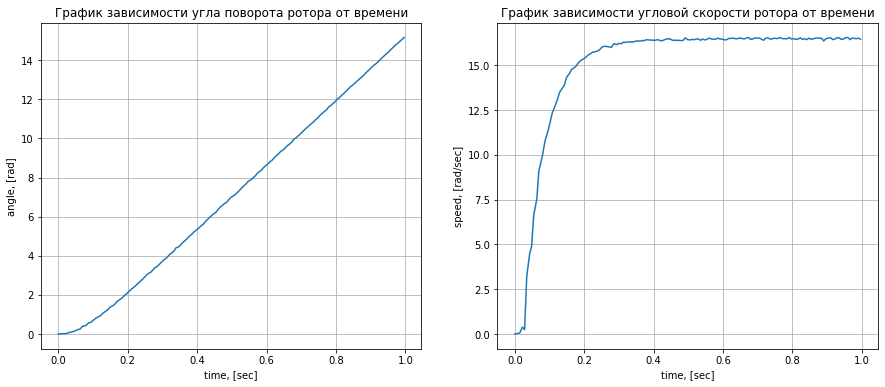

In [19]:
# Импортируем модуль matplotlib.pyplot для построения графиков
%matplotlib inline
from matplotlib import pyplot as plt

# Построим графики зависимости angle(time), speed(time)
# Выделяем место под два смежных графика
fig, ax = plt.subplots(1,2, figsize=(15,6)) 
# График angle(time)
ax[0].plot(data.time, data.angle)
ax[0].set_title("График зависимости угла поворота ротора от времени")
ax[0].set_xlabel("time, [sec]")
ax[0].set_ylabel("angle, [rad]")
ax[0].grid()
# График speed(time)
ax[1].plot(data.time, data.speed)
ax[1].set_title("График зависимости угловой скорости ротора от времени")
ax[1].set_xlabel("time, [sec]")
ax[1].set_ylabel("speed, [rad/sec]")
ax[1].grid()

Найдем аппроксимирующую функцию для обоих графиков  

Для этого применим метод наименьших квадратов.  
Итак, нам необходимо найти параметры $\omega_{nls}$ и $T_m$ функции $f(t) = \omega_{nls} \left(t - T_m \left(1 - \exp\left(-\frac{t}{T_m}\right)\right)\right)$.  
Воспользуемся модулем `scipy.optimize`

In [20]:
# Импортируем numpy
import numpy as np

# Определим данные, полученные с двигателя
x_samp = np.array(data.time)
y_samp = np.array(data.angle)

In [21]:
# Определим вид нашей функции
def f(t, k, m):
    return k * (t - m * (1 - np.exp(- t / m)))

In [22]:
# Определим область определения аппроксимирующей функции
x_lin = np.linspace(0, x_samp.max(), len(data))

In [23]:
# Импортируем модуль scipy.optimize
from scipy import optimize

# Запишим предположительные значения параметров
p0 = [15, 0.06]

# Выполним аппроксимацию и запишем результаты наших параметров
w_nls, T_m = optimize.curve_fit(f, x_samp, y_samp, p0=p0)[0]
w_nls, T_m

(16.506986002066874, 0.07695944988573092)

Text(0.5, 1.0, 'Аппроксимация зависимости угла поворота от времени')

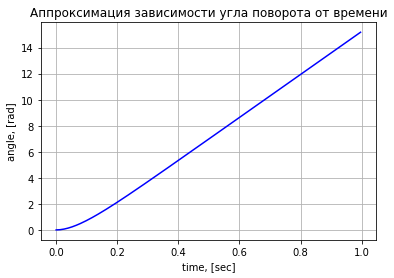

In [24]:
# Построим график аппроксимации
plt.plot(x_lin, f(x_lin, w_nls, T_m), color='blue')
plt.grid()
plt.xlabel('time, [sec]')
plt.ylabel('angle, [rad]')
plt.title('Аппроксимация зависимости угла поворота от времени')

Аналогично можно найти аппроксимацию зависимости угловой скорости ротора от времени

In [25]:
# Определим данные, полученные с двигателя
y_samp = np.array(data.speed)

# Определим вид нашей функции
def f(t, k, m):
    return k * (1 - np.exp(- t / m))

# Выполним аппроксимацию и запишем результаты наших параметров
w_nls, T_m = optimize.curve_fit(f, x_samp, y_samp, p0=p0)[0]
w_nls, T_m

(16.586755670112378, 0.08866729817944666)

Text(0.5, 1.0, 'Аппроксимация зависимости угловой скорости от времени')

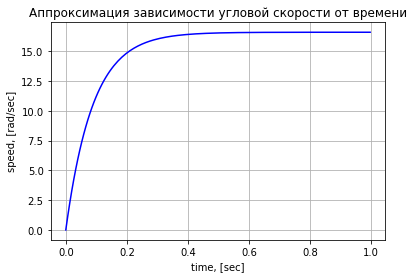

In [26]:
# Построим график аппроксимации
plt.plot(x_lin, f(x_lin, w_nls, T_m), color='blue')
plt.grid()
plt.xlabel('time, [sec]')
plt.ylabel('speed, [rad/sec]')
plt.title('Аппроксимация зависимости угловой скорости от времени')


Построив такие же графики для других значений напряжения, поданного на ротор, можно убедиться в справедливости функций, описывающих работу ненагруженного двигателя постоянного тока.

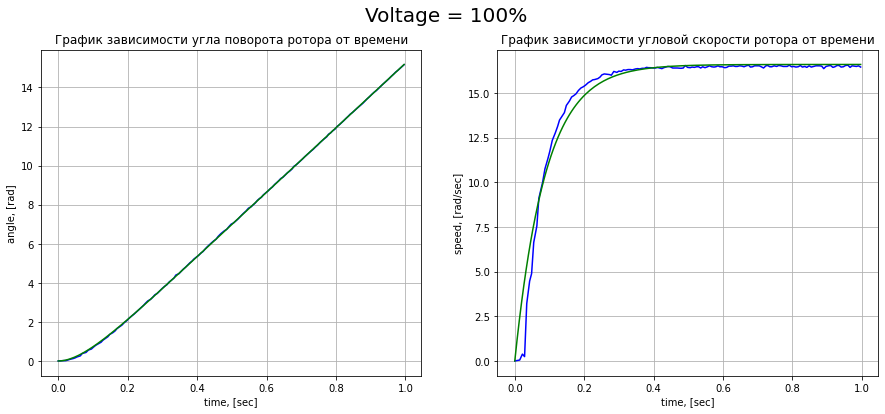

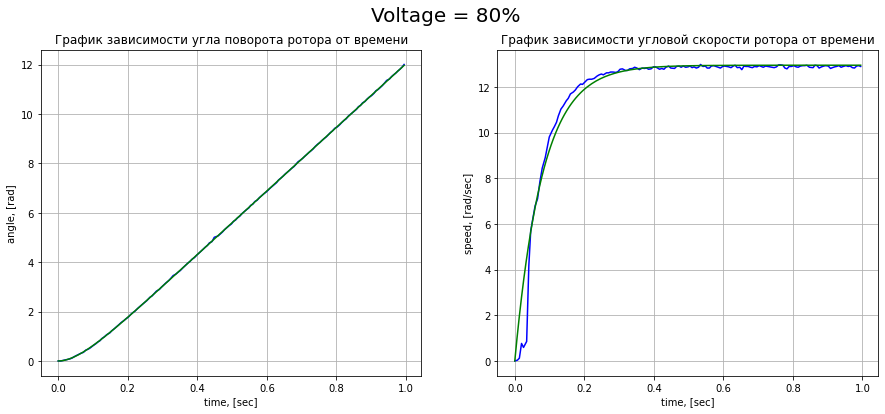

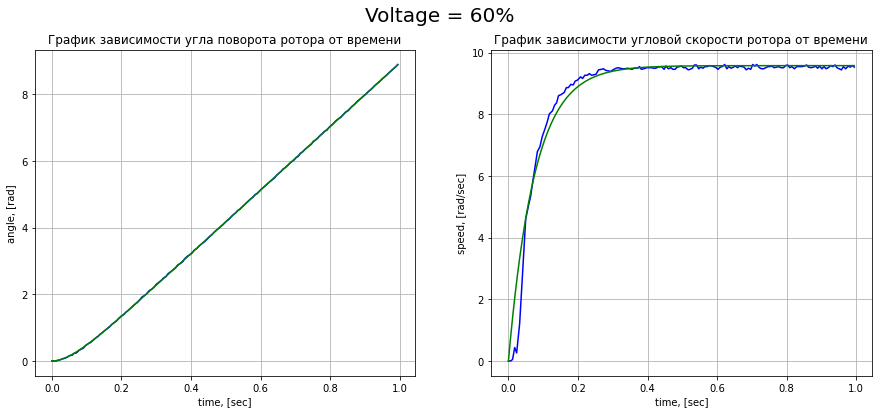

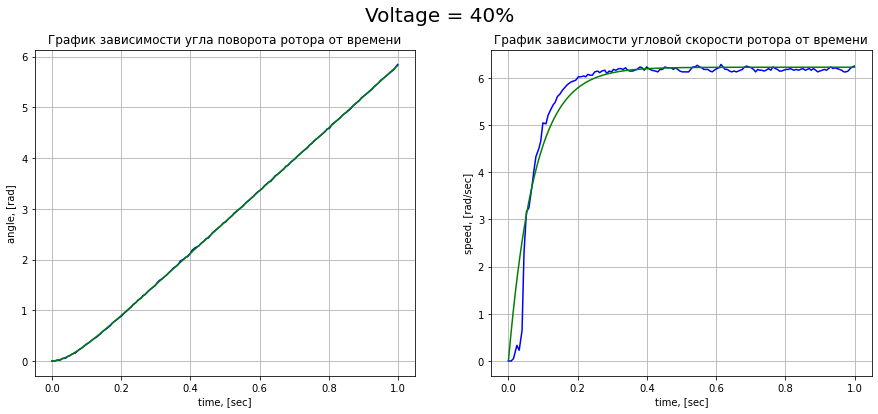

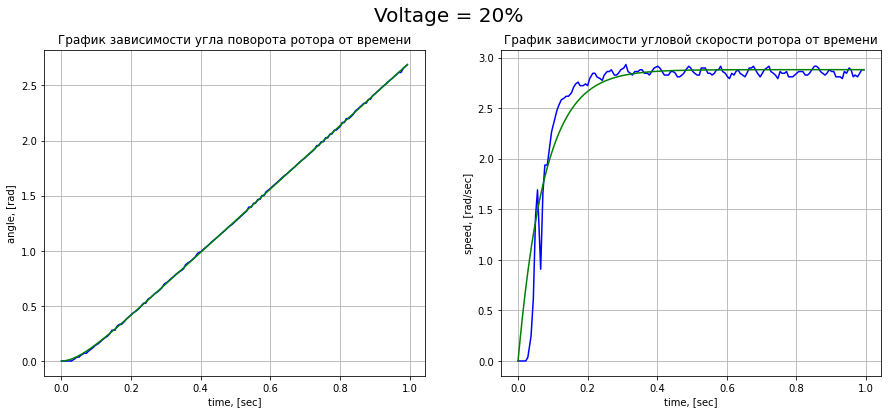

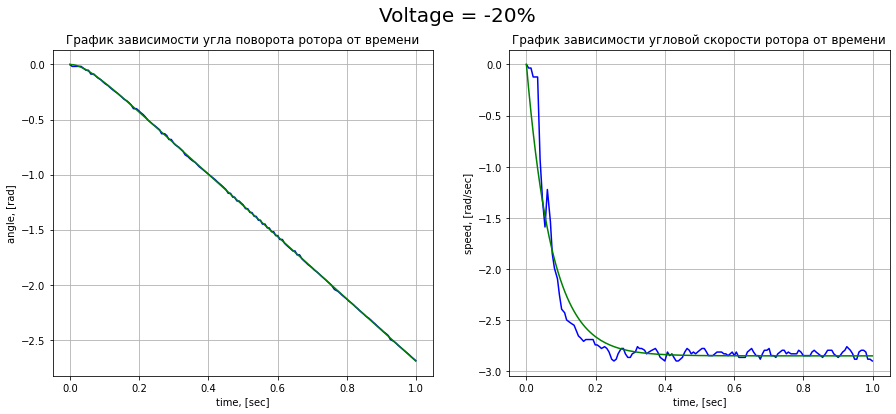

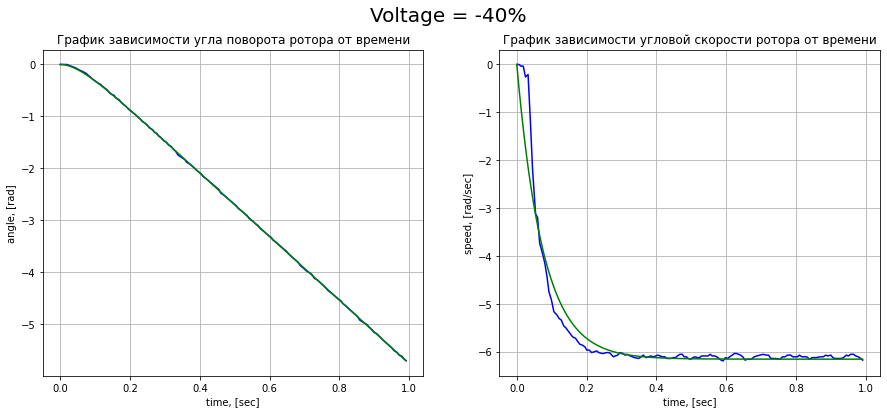

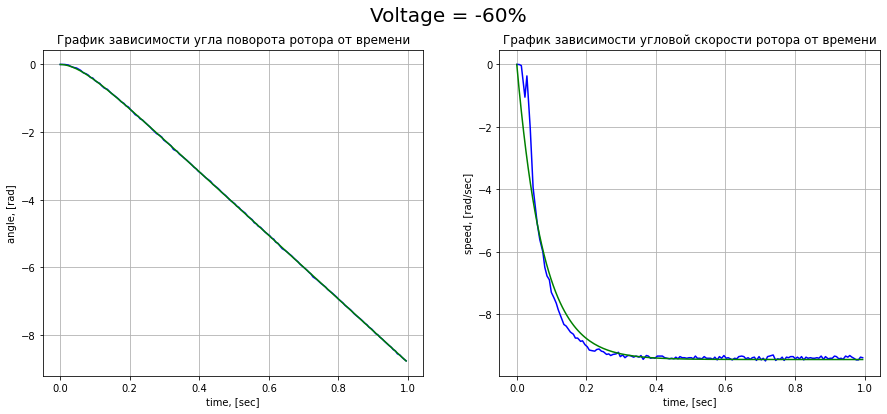

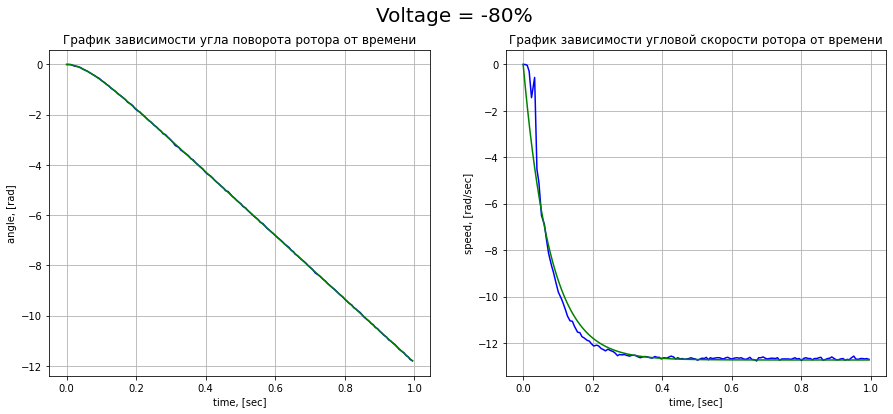

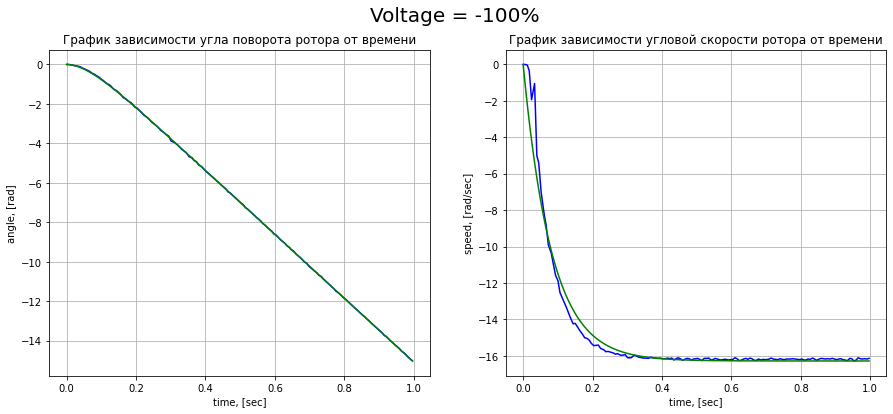

In [29]:
def f_angle(t, k, m):
    return k * (t - m * (1 - np.exp(- t / m)))

def f_speed(t, k, m):
    return k * (1 - np.exp(- t / m))

wnls_angle_list = []
Tm_angle_list = []
wnls_speed_list = []
Tm_speed_list = []

for i in range(100, -120, -20):
    if i == 0: continue
    data = pd.read_csv(".\data" + str(i) + ".txt", delimiter=" ", header=0)
    data['angle'] = data['angle'].map(math.radians)
    data['speed'] = data['speed'].map(math.radians)
    
    x_samp = np.array(data.time)
    y_angle_samp = np.array(data.angle)
    y_speed_samp = np.array(data.speed)
    
    x_lin = np.linspace(0, x_samp.max(), len(data))
    
    p0 = [15 * math.copysign(1, i), 0.06]

    w_nls_angle, T_m_angle = optimize.curve_fit(f_angle, x_samp, y_angle_samp, p0=p0)[0]
    w_nls_speed, T_m_speed = optimize.curve_fit(f_speed, x_samp, y_speed_samp, p0=p0)[0]
    wnls_angle_list.append(w_nls_angle)
    wnls_speed_list.append(w_nls_speed)
    Tm_angle_list.append(T_m_angle)
    Tm_speed_list.append(T_m_speed)
    
    fig, ax = plt.subplots(1,2, figsize=(15,6)) 
    
    ax[0].plot(x_samp, y_angle_samp, color="blue")
    ax[0].plot(x_lin, f_angle(x_lin, w_nls_angle, T_m_angle), color="green")
    ax[0].set_title("График зависимости угла поворота ротора от времени")
    ax[0].set_xlabel("time, [sec]")
    ax[0].set_ylabel("angle, [rad]")
    ax[0].grid()
    
    ax[1].plot(x_samp, y_speed_samp, color="blue")
    ax[1].plot(x_lin, f_speed(x_lin, w_nls_speed, T_m_speed), color="green")
    ax[1].set_title("График зависимости угловой скорости ротора от времени")
    ax[1].set_xlabel("time, [sec]")
    ax[1].set_ylabel("speed, [rad/sec]")
    ax[1].grid()
    
    fig.suptitle("Voltage = " + str(i) + "%", fontsize=20)

Теперь, имея все значения $\omega_{nls}$ и $T_m$ можем построить их графики зависимости от Voltage

Text(0.5, 0.98, 'Значения, полученные при аппроксимации угла поворота ротора')

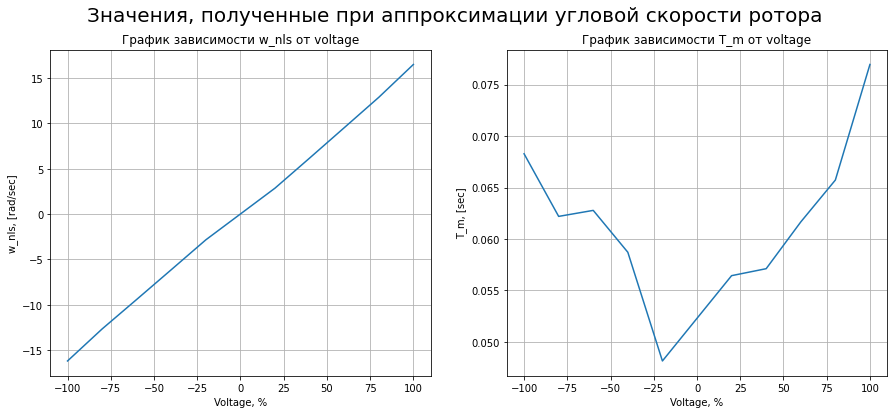

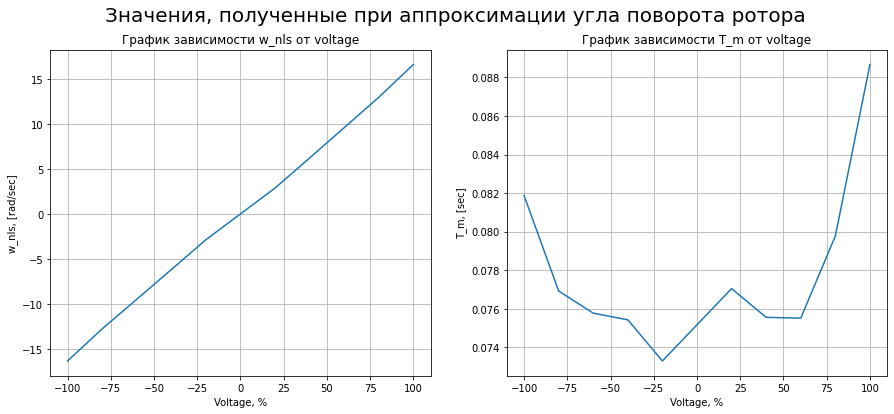

In [28]:
Voltage = [i for i in range(100, -120, -20) if i != 0]
fig, ax = plt.subplots(1,2, figsize=(15,6)) 
ax[0].plot(Voltage, wnls_angle_list)
ax[0].set_title("График зависимости w_nls от voltage")
ax[0].set_xlabel("Voltage, %")
ax[0].set_ylabel("w_nls, [rad/sec]")
ax[0].grid()

ax[1].plot(Voltage, Tm_angle_list)
ax[1].set_title("График зависимости T_m от voltage")
ax[1].set_xlabel("Voltage, %")
ax[1].set_ylabel("T_m, [sec]")
ax[1].grid()

fig.suptitle("Значения, полученные при аппроксимации угловой скорости ротора", fontsize=20)

fig, ax = plt.subplots(1,2, figsize=(15,6)) 
ax[0].plot(Voltage, wnls_speed_list)
ax[0].set_title("График зависимости w_nls от voltage")
ax[0].set_xlabel("Voltage, %")
ax[0].set_ylabel("w_nls, [rad/sec]")
ax[0].grid()

ax[1].plot(Voltage, Tm_speed_list)
ax[1].set_title("График зависимости T_m от voltage")
ax[1].set_xlabel("Voltage, %")
ax[1].set_ylabel("T_m, [sec]")
ax[1].grid()

fig.suptitle("Значения, полученные при аппроксимации угла поворота ротора", fontsize=20)

### Выводы
1. В ходе выполнения лабораторной работы были достигнуты цели, поставленные ранее. Путем сбора и анализа экспериментальных данных и последующего построения графиков доказана справедливость функций, описывающих работу ненагруженного двигателя постоянного тока (данный вывод мы делаем из того, что кривые разгона двигателя (построенная по экспериментальным данным, построенная в соответствии с теоретически выведенным выражением по числовым значениям, полученным в результате аппроксимации) практически совпадают), а также определены значения параметров $T_m$ и $\omega_{nls}$ 
2. Результатом выполнения лабораторной работы стали построенные графики Angle(time) и Speed(time), выражающие зависимость угла поворота от времени и угловой скорости от времени при разных значениях voltage.
3. Были установлены зависимости $T_m(voltage)$ и $\omega_{nls}(voltage)$. Зависимость $\omega_{nls}(voltage)$ имеет линейный характер, что следует из формулы для определения угловой скорости: $\omega_{nls} = \frac{U}{k_e}$. График $T_m(voltage)$ представлен в виде ломаной линии, характер изменения которой сложно установить. 
4. Мы сделали вывод, что робототехника требует знаний не только в области программирования, но и в областях математики и физики. Пока мы не вникли в теорию, изложенную в методичке, анализ данных был совершенно непонятным.  
6. Не желая делать все замеры руками, мы после нескольких неудачных попыток смогли оптимизировать код на Python, производя замеры на разных скоростях при помощи цикла for. 
